# Overview
Use this notebook to convert an OCT image you have to a virtual H&E image for evaluation.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/zero_shot_segmentation_oct.ipynb)
 and run.


# inputs

Assumptions:

oct scan x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 1

pix2pix input sizes:
*   virtual histology input width = 256
*   virtual histology input height = 256

pix2pix input x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 2

In [1]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/z-stacking/croppedimage2.png"

In [20]:
#visualization of virtual histology
visualize_oct2hist_outputs = False
#visualization size
FIG_SIZE = (10,5)

In [3]:
#rf - roboflow dataset related params
rf_api_key="R04BinsZcBZ6PsfKR2fP"
rf_workspace="yolab-kmmfx"
rf_project = "connect_from_colab"
rf_dataset = "png-mask-semantic"

In [4]:
#segment anything (sam)
using_colab = True
visualize_sam_outputs = True

#sam algorithm input parameters
points_per_side=32
pred_iou_thresh=0.90
stability_score_thresh=0.95
crop_n_layers=1
crop_n_points_downscale_factor=2
min_mask_region_area=3000

#sam model type and weights checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

#Zero shot pipeline

In [5]:
import torch
import torchvision
import os

# Clone repository, run setup on first load
if not 'setup_env_oct2Hist_usemodel' in globals():
  setup_env_oct2Hist_usemodel = True
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel
  %run /content/OCT2Hist-UseModel/setup_env.ipynb



Cloning into 'OCT2Hist-UseModel'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 274 (delta 0), reused 4 (delta 0), pack-reused 270
Receiving objects: 100% (274/274), 9.30 MiB | 19.32 MiB/s, done.
Resolving deltas: 100% (154/154), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 20.67 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
Mounted at /content/drive/
/content/OCT2Hist-UseModel
Drive already mounted at /content/drive/; to attem

In [23]:
#go back to initial dir
%cd "/content"
!git clone --recurse-submodules https://github.com/WinetraubLab/zero_shot_segmentation.git


/content
Cloning into 'zero_shot_segmentation'...
fatal: could not read Username for 'https://github.com': No such device or address


In [22]:
# !rm -rf "/content/zero_shot_segmentation"

In [24]:
%pip install dataclasses-json
%pip install supervision

In [25]:
from zero_shot_segmentation.zero_shot_utils.utils import *

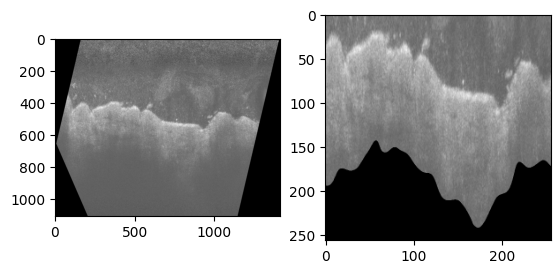

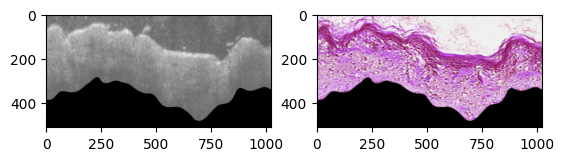

In [26]:
%run /content/OCT2Hist-UseModel/ConvertOCTImagesToHistology.ipynb

#run sam on virtual histology

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [27]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=rf_api_key)
project = rf.workspace(rf_workspace).project(rf_project)
dataset = project.version(1).download(rf_dataset)

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to connect_from_colab-1 in png-mask-semantic:: 100%|██████████| 6/6 [00:00<00:00, 2092.27it/s]


In [28]:
import os
DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)
print(IMAGES_DIRECTORY_PATH)
print(ANNOTATIONS_FILE_PATH)

/content/connect_from_colab-1/test
/content/connect_from_colab-1/test/_annotations.coco.json


In [29]:
if using_colab:
  print("PyTorch version:", torch.__version__)
  print("Torchvision version:", torchvision.__version__)
  print("CUDA is available:", torch.cuda.is_available())
  import sys
  !{sys.executable} -m pip install opencv-python matplotlib
  !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  !mkdir images
  !wget -P images https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg&name=large
#https://twitter.com/JMGardnerMD/status/1655724394805706752/photo/1
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-k2dl_yr8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-k2dl_yr8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2023-08-23 18:00:18--  https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 93.184.220.70, 2606:2800:134:1a0d:1429:742:782:b6
Connecting to pbs.twimg.com (pbs.twimg.com)|93.184.220.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254202 (248K) [image/jpeg]
Saving to: ‘images/FvpQj7UWYAAgxfo?format=jpg.1’

FvpQj7UWYAAgxfo?for 100%[===================>] 248.24K  --.-KB/s    in 0.01s   


## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(virtual_histology_image_resized)

In [ ]:
if visualize_sam_outputs:
  visualize_masks(virtual_histology_image_resized, masks, FIG_SIZE)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:[link text](https://)


In [ ]:
if visualize_sam_outputs:
  visualize_masks(masks)

#project on oct

In [ ]:
visualize_masks(cropped, masks, FIG_SIZE)